# Project Fake or True by text Twitter
submit by:
daniel zaguri - 203289780
elad ben haim - 301416467

* [Preprocessing the data frame](#pre)
* [Feature statistics](#stat)
* [Feature selection](#select)
* [Analyze Data](#analyze)
    * [Distribution of common words](#dist)
    * [World map of reliable words](#real)
    * [World map of unreliable words](#fake)
* [One encoding](#encoding)
* [Model and avaluate](#model)
* [Results analysis](#result)
* [Regularization](#regular)
* [Confusion matrix](#confusion)
* [Improve predict](#improve)
    * [Improve by probability (20%-80%)](#prob)
    * [Improve by Fake/True Author > 17](#auth)

<a id='pre'></a>

## Preprocessing

In [1]:
import numpy as np 
import pandas as pd 

In [2]:
train=pd.read_csv('train.csv')
train.head(6)

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1
5,5,Jackie Mason: Hollywood Would Love Trump if He...,Daniel Nussbaum,"In these trying times, Jackie Mason is the Voi...",0


In [3]:
train.isnull().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

In [4]:
print("shape is : rows={}, cols={}".format(train.shape[0], train.shape[1]))

shape is : rows=20800, cols=5


In [5]:
train.dropna(subset = ["text"], inplace=True)
train.isnull().sum()

id           0
title      558
author    1918
text         0
label        0
dtype: int64

<a id='stat'></a>

## Feature Statistics

<AxesSubplot:xlabel='count', ylabel='label'>

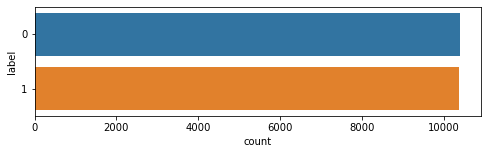

In [6]:
# visualise data

import matplotlib.pyplot as plt
import seaborn as sns

# seeing the balance of the two labels 
# 1 = unreliable / fake
# 0 = reliable / real
plt.figure(figsize = (8, 2))
sns.countplot(y = train.label)

In [7]:
train.groupby('label')['author'].nunique()

label
0    2225
1    1981
Name: author, dtype: int64

In [8]:
t = train.loc[train['label'] == 0].author.value_counts()
t

Pam Key                                 242
Jerome Hudson                           166
Charlie Spiering                        141
John Hayward                            140
Katherine Rodriguez                     124
                                       ... 
Ian Buruma                                1
Keith Schneider                           1
Ivor Prickett For The New York Times      1
Rana F. Sweis                             1
Casey Schwartz                            1
Name: author, Length: 2225, dtype: int64

In [9]:
f = train.loc[train['label'] == 1].author.value_counts()
f

admin                                                              193
Pakalert                                                            86
Eddy Lavine                                                         85
Starkman                                                            84
Gillian                                                             82
                                                                  ... 
WhiteDawn                                                            1
New Moon In Scorpio: Making A Calculated Effort – Motivate3.com      1
Swath - PROUD DEPLORABLE                                             1
reasoning with facts                                                 1
Ian                                                                  1
Name: author, Length: 1981, dtype: int64

In [10]:
dic = {}
for i in range(0,len(t)):
    autht = t.index[i]
    if autht in f:
        dic[autht] = {'true':t[i],'fake':f[autht]}
    else:
        dic[autht] = {'true':t[i],'fake':0}


In [11]:
for item in f.index:
    if item not in dic:
        dic[item] = {'true':0,'fake':f[item]}
        
len(dic)


4201

In [12]:
dic

{'Pam Key': {'true': 242, 'fake': 1},
 'Jerome Hudson': {'true': 166, 'fake': 0},
 'Charlie Spiering': {'true': 141, 'fake': 0},
 'John Hayward': {'true': 140, 'fake': 0},
 'Katherine Rodriguez': {'true': 124, 'fake': 0},
 'Warner Todd Huston': {'true': 122, 'fake': 0},
 'Ian Hanchett': {'true': 119, 'fake': 0},
 'Breitbart News': {'true': 118, 'fake': 0},
 'Daniel Nussbaum': {'true': 112, 'fake': 0},
 'AWR Hawkins': {'true': 107, 'fake': 0},
 'Jeff Poor': {'true': 107, 'fake': 0},
 'Joel B. Pollak': {'true': 106, 'fake': 0},
 'Trent Baker': {'true': 102, 'fake': 0},
 'Breitbart London': {'true': 97, 'fake': 0},
 'Bob Price': {'true': 93, 'fake': 0},
 'Ben Kew': {'true': 90, 'fake': 0},
 'Charlie Nash': {'true': 88, 'fake': 0},
 'Lucas Nolan': {'true': 80, 'fake': 0},
 'Breitbart Jerusalem': {'true': 75, 'fake': 0},
 'John Binder': {'true': 75, 'fake': 0},
 'Penny Starr': {'true': 67, 'fake': 0},
 'Tom Ciccotta': {'true': 64, 'fake': 0},
 'Frances Martel': {'true': 64, 'fake': 0},
 'Dr

<a id='select'></a>

## Feature Selection

In [ ]:
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re
from string import punctuation

# create a list of stop words - common words that will have little to no predictive value
stop_words = stopwords.words("english")

# stems words such as plurals (not that accurate)
ps = PorterStemmer()

def preprocess(text):

    text = re.sub("[^a-zA-Z]", " ", text)
    text = text.lower().split()
    text = [ps.stem(word) for word in text if word not in stop_words]
    text = " ".join(text)
    text = "".join(p for p in text if p not in punctuation)
    
    return text



train["after"] = train["text"].apply(preprocess)

In [ ]:
import keras
from keras import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# word tokenizer
vocab_size = 20000

tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(train.after)
train_sequences = tokenizer.texts_to_sequences(train.after)

In [ ]:
flat_list = []
for sublist in train.after:
    x = sublist.split()
    flat_list.append(x)

In [ ]:
flattened = [val for sublist in flat_list for val in sublist]

<a id='analyze'></a>

## Analyze the data

In [ ]:
import nltk
fdist_filtered = nltk.FreqDist(flattened)

<a id='dist'></a>

### Distribution of 30 common words in text

In [ ]:
fdist_filtered.plot(30,title='Frequency distribution for 30 most common words in our text collection (excluding stopwords and punctuation)')

<a id='real'></a>

### World map of reliable words

In [ ]:
from wordcloud import WordCloud
plt.figure(figsize=(20,20))
wordCloud = WordCloud(max_words = 1000 , width = 1600 , height = 800 , stopwords = stop_words).generate(" ".join(train[train["label"] == 0]["after"]))
plt.title("Wordmap of words for real news")
plt.imshow(wordCloud, interpolation = "bilinear")

<a id='fake'></a>

### World map of fake words

In [ ]:
plt.figure(figsize=(20,20))
wordCloud = WordCloud(max_words = 1000 , width = 1600 , height = 800 , stopwords = stop_words).generate(" ".join(train[train["label"] == 1]["after"]))
plt.title("Wordmap of words for fake news")
plt.imshow(wordCloud, interpolation = "bilinear")

In [ ]:
reverse_word_index = dict([(value, key) for (key, value) in tokenizer.word_index.items()])
decoded_review = ' '.join([reverse_word_index.get(i) for i in train_sequences[4]])
decoded_review

In [ ]:
print(len(train_sequences))

In [ ]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(train_sequences,train.label,test_size=0.3)

<a id='encoding'></a>

## One encoding

In [ ]:

def vectorize_sequences(sequences, dimension=vocab_size):
    # Create an all-zero matrix of shape (len(sequences), dimension)
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.  # set specific indices of results[i] to 1s
    return results

# Our vectorized training data
x_train = vectorize_sequences(X_train)
# Our vectorized test data
x_test = vectorize_sequences(X_test)

In [ ]:
# Our vectorized labels
y_train = np.asarray(y_train).astype('float32')
y_test = np.asarray(y_test).astype('float32')

<a id='model'></a>

## Model and evaluate

In [ ]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(vocab_size,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
from keras import optimizers

model.compile(optimizer=optimizers.RMSprop(lr=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
from keras import losses
from keras import metrics

model.compile(optimizer=optimizers.RMSprop(lr=0.001),
              loss=losses.binary_crossentropy,
              metrics=[metrics.binary_accuracy])

In [ ]:
x_val = x_train[:6000]
partial_x_train = x_train[6000:]

y_val = y_train[:6000]
partial_y_train = y_train[6000:]

In [ ]:
original_model = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

In [ ]:
org_model_dict = original_model.history
org_model_dict.keys()

<a id='result'></a>

## Results analysis

In [ ]:
import matplotlib.pyplot as plt

acc = original_model.history['binary_accuracy']
val_acc = original_model.history['val_binary_accuracy']
loss = original_model.history['loss']
val_loss = original_model.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
plt.clf()   # clear figure
acc_values = org_model_dict['binary_accuracy']
val_acc_values = org_model_dict['val_binary_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(vocab_size,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=4, batch_size=512)
results = model.evaluate(x_test, y_test)

In [ ]:
results

In [ ]:
pred = model.predict(x_test)

In [ ]:
df_res = pd.DataFrame(list(zip((pred>0.5).astype('int32'), y_test)), columns =['Predict', 'true'])
df_res.head()

In [ ]:
count = 0
for index, row in df_res.iterrows(): 
    if row.Predict == row.true:
        count = count + 1
per =round((count/len(x_test))*100,2)
print(per)

<a id='regular'></a>

## Regularization tests

In [ ]:
from keras import regularizers
reg_model = models.Sequential()
reg_model.add(layers.Dense(16, activation='relu', input_shape=(vocab_size,)))
reg_model.add(layers.Dropout(0.3))
reg_model.add(layers.Dense(16, activation='relu'))
reg_model.add(layers.Dropout(0.3))
reg_model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
reg_model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
reg_model.compile(optimizer=optimizers.RMSprop(lr=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
reg_model.compile(optimizer=optimizers.RMSprop(lr=0.001),
              loss=losses.binary_crossentropy,
              metrics=[metrics.binary_accuracy])

In [ ]:
reg_model = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

In [ ]:
reg_model_dict = reg_model.history
reg_model_dict.keys()

In [ ]:
val_loss = original_model.history['val_loss']
reg_val_loss=reg_model.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, reg_val_loss, 'bo', label='Dropout Regularization Model')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Originial Model')
plt.title('Dropout vs Original')
plt.xlabel('Epochs')
plt.ylabel('Val Loss')
plt.legend()

plt.show()

<a id='confusion'></a>

## Confusion matrix

In [ ]:
%matplotlib inline
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

In [ ]:
cm = confusion_matrix(y_pred=(pred>0.5).astype('int32'),y_true=y_test)

In [ ]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Predicted label')
    plt.xlabel('True label')

In [ ]:
cm_plot_labels = ['Reliable','Fake']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [ ]:
tag_counter = []
count_tag = 0
count_tag_and_fake= 0 
count_tag_and_real= 0 


for item in train['text']:
    x = item.split('@')
    tag_counter.append(len(x)-1)
    x=[]
    
temp = np.asarray(train['label']).astype('int32')
for i in range(0,len(tag_counter)):
    if temp[i]==1 and tag_counter[i]>0:
        count_tag_and_fake = count_tag_and_fake+tag_counter[i]
    elif temp[i]==0 and tag_counter[i]>0:
        count_tag_and_real = count_tag_and_real+tag_counter[i]


print(count_tag_and_fake/len(train.loc[train['label'] == 1]))
print(count_tag_and_real/len(train.loc[train['label'] == 0]))
    
    
    


<a id='improve'></a>

## Improve prediction by author or probability

In [ ]:
i=0
t1=[]
for each in X_test:
    t1.append(train.iloc[train_sequences.index(each)].author) 
df_res_2 = df_res
df_res_2['Author'] = t1
df_res_2['checkAmount'] = 0
for each in df_res_2['Author']:
    if str(each)!='nan':
        if dic[each]['true']>dic[each]['fake']:
            df_res_2['checkAmount'][i] = 0
        elif dic[each]['true']<dic[each]['fake']:
            df_res_2['checkAmount'][i] = 1
    
    i=i+1
    
df_res_2

<a id='prob'></a>

### Improve the prediction by probability of fake above 0.8 and true under 0.2

In [ ]:
df_res_2['predPercent'] = "0"
count=0
for each in df_res_2.iterrows():
    if pred[count]<0.8 and pred[count]>0.2 : 
        df_res_2['predPercent'].iloc[count] = pred[count]
    else :
        if pred[count]<=0.2 : 
            df_res_2['predPercent'].iloc[count] = 0
        else :
            df_res_2['predPercent'].iloc[count] = 1
    count=count+1
df_res_2
    

In [ ]:
indx = 0
for each in df_res_2.predPercent:
    if each > 0 and each  < 1:
        df_res_2['predPercent'].iloc[indx] = df_res_2['checkAmount'][indx]
    indx = indx + 1
df_res_2

In [ ]:
count = 0
countSame=0
for each in df_res_2.true:
    if each == df_res_2['predPercent'][count]:
        countSame = countSame +1
    count = count + 1
print(countSame/len(df_res_2)*100)
print("difference of  : %.2f percentages" % round((countSame/len(df_res_2)*100 -per) , 2 ))

<a id='auth'></a>

### Improve the prediction Author by the most of his tweets 

In [ ]:

df_res_2['predByAuthor'] = df_res_2['Predict']

for count in range(0,len(df_res_2)):
    if str(df_res_2['Author'][count])!='nan':
        if dic[df_res_2['Author'][count]]['true']>=10:
            df_res_2.predByAuthor.iloc[count] = 0
        if dic[df_res_2['Author'][count]]['fake']>=10:
            df_res_2.predByAuthor.iloc[count] = 1
df_res_2

In [ ]:
count = 0
countSame=0
for each in df_res_2.true:
    if each == df_res_2['predByAuthor'][count]:
        countSame = countSame +1
    count = count + 1
print(countSame/len(df_res_2)*100)
print("difference of : %.2f percentages" % round((countSame/len(df_res_2)*100 - per) , 2 ))